In [1]:
import urllib.request
import json
import numpy as np
import pandas as pd
from joblib import load
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [228]:
def custom_analyzer(doc):
    return doc

cardVec = load('matrix_data/cardVecTF_MIX_11k_20dim.joblib')
deckVecorizer = load('matrix_data/deckVectorizer_MIX_11k_30K.joblib')

In [229]:
deckVecorizer

TfidfVectorizer(analyzer=<function custom_analyzer at 0x000002145F07EAF0>,
                lowercase=False,
                vocabulary=['Strike_R', 'Bash', 'Anger', 'Body Slam', 'Clash',
                            'Cleave', 'Clothesline', 'Headbutt', 'Heavy Blade',
                            'Iron Wave', 'Perfected Strike', 'Pommel Strike',
                            'Sword Boomerang', 'Thunderclap', 'Twin Strike',
                            'Wild Strike', 'Blood for Blood', 'Carnage',
                            'Dropkick', 'Hemokinesis', 'Pummel', 'Rampage',
                            'Reckless Charge', 'Searing Blow', 'Sever Soul',
                            'Uppercut', 'Whirlwind', 'Bludgeon', 'Feed',
                            'Fiend Fire', ...])

In [230]:
data_url1 = 'data/processed_data/picked_TS_5k_14k.json'
TS_pick = pd.read_json(data_url1)
data_url2 = 'data/processed_data/picked_8k_30k.json'
IC_pick = pd.read_json(data_url2)

In [231]:
IC_pick_sample = IC_pick.sample(n=15000).reset_index()

In [232]:
pick = pd.concat([TS_pick, IC_pick_sample], ignore_index=True).sample(frac=1).reset_index(drop=True)

kerass

In [233]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
import keras

In [234]:
keras.utils.set_random_seed(812)

In [235]:
X = deckVecorizer.fit_transform(pick.deck.tolist())
X = X.toarray()
x_card = pick.deck.tolist()
y = [cardVec[picked] for picked in pick.picked ]
y_card = pick.picked 

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)
y_card = np.array(y_card, dtype= str)

# Split data into training and testing sets
X_train, X_test, y_train, y_test, yC_train,yC_test ,xC_train,xC_test= train_test_split(X, y,y_card,x_card,  test_size=0.2,  shuffle=True)


In [236]:
X.shape

(29413, 379)

In [237]:
y.shape

(29413, 20)

In [238]:
# Standardize the data
### scaler = StandardScaler()
## X_train = scaler.fit_transform(X_train)
## X_test = scaler.transform(X_test)

In [239]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
def cosine_similarity_loss(y_true, y_pred):
    # Compute the dot product between y_true and y_pred
    dot_product = tf.reduce_sum(tf.multiply(y_true, y_pred), axis=-1)
    
    # Compute the norm of y_true and y_pred
    norm_y_true = tf.sqrt(tf.reduce_sum(tf.square(y_true), axis=-1))
    norm_y_pred = tf.sqrt(tf.reduce_sum(tf.square(y_pred), axis=-1))
    
    # Compute cosine similarity
    cosine_similarity = dot_product / (norm_y_true * norm_y_pred + tf.keras.backend.epsilon())
    
    # Cosine similarity ranges from -1 to 1, so we convert it to a loss value by subtracting from 1
    return 1 - cosine_similarity

In [240]:
def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm1 = np.linalg.norm(vector1)
    norm2 = np.linalg.norm(vector2)
    if norm1 == 0 or norm2 == 0:
        return np.array(0.0)
    similarity = dot_product / (norm1 * norm2)
    return similarity

In [241]:
model = Sequential([
    Input(shape=(379,)),# Define the input shape

    Dense(256, activation='relu' ),     
   
    
    Dense(128, activation='relu'),     

    
    Dense(64, activation='relu' ),  
    Dense(32, activation='relu' ),  

    Dense(20)          
])
# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss= cosine_similarity_loss) 

In [242]:
# If you need it in the form of a History-like object
class HistoryMock:
    def __init__(self):
        self.history = {'loss': [], 'accuracy': []}  # Add other metrics as needed

history = HistoryMock()

In [243]:
# Train the model
history_tmp = model.fit(X_train, y_train, epochs=60,batch_size=16,verbose=0)

In [244]:
for key in history_tmp.history.keys():
    if key in history.history:
        history.history[key].extend(history_tmp.history[key])
    else:
        history.history[key] = history_tmp.history[key]

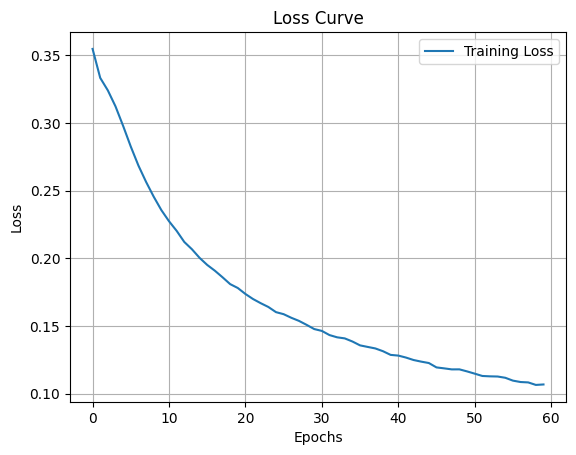

In [245]:
import matplotlib.pyplot as plt

# Extract loss values from the history object
loss = history.history['loss']

# If you have validation data
val_loss = history.history.get('val_loss', None)

# Plot the training loss
plt.plot(loss, label='Training Loss')

# Plot validation loss if available
if val_loss:
    plt.plot(val_loss, label='Validation Loss')

# Customize the plot
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [251]:

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test, verbose=1)

# If loss is a list, print the first element as the test loss
print(f'Test Loss: {loss[0]:.4f}' if isinstance(loss, list) else f'Test Loss: {loss:.4f}')

# Make predictions (optional)
predictions = model.predict(X_test)
simility_test = list()
for pred, pick_card in zip(predictions , yC_test):
    simility_test.append(cosine_similarity(pred, cardVec[pick_card]))

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4499
Test Loss: 0.4543
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step


In [252]:
mt = pd.DataFrame()

In [253]:
mt['similate'] = simility_test

In [254]:
mt.count

<bound method DataFrame.count of       similate
0     0.955057
1     0.754965
2     0.923854
3     0.879912
4     0.561801
...        ...
5878  0.439951
5879   0.85079
5880  0.958291
5881  0.561965
5882  0.614232

[5883 rows x 1 columns]>

In [255]:
print((mt.loc[ mt.similate > 0.3].count().similate )/5883)
print((mt.loc[ mt.similate > 0.5].count().similate )/5883)
print((mt.loc[ mt.similate > 0.7].count().similate )/5883)

0.7382287948325684
0.6070032296447391
0.43685194628590857


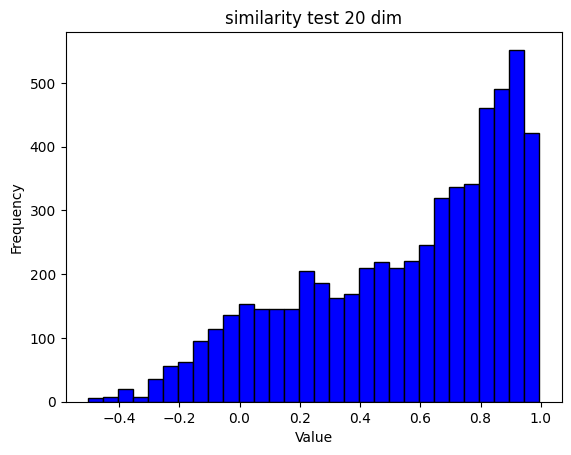

In [256]:
import matplotlib.pyplot as plt

# Drop NaN values before plotting
data = mt['similate'].dropna()

# Plot histogram
plt.hist(data, bins=30, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("similarity test 20 dim")

# Display the plot
plt.show()

In [257]:
ic_smaple = [ [ ["Strike_R"] * 5 + ["Defend_R"] * 5 + ["Bash"]+['Shrug It Off']*0] ,
             [ ["Strike_R"] * 5 + ["Defend_R"] * 10 + ["Bash"]+['Shrug It Off']*0] ,
             [ ["Strike_R"] * 5 + ["Defend_R"] * 0 + ["Bash"]+['Shrug It Off']*0] ,
             [ ["Strike_R"] * 5 + ["Defend_R"] * 5 + ["Bash"]+['Shrug It Off']*1] ,
             [ ["Strike_R"] * 5 + ["Defend_R"] * 5 + ["Bash"]+['Shrug It Off']*3] ]

In [258]:
sample = [deckVecorizer.transform(deck).toarray() for deck in ic_smaple]
sample_pred = [model.predict(deck) for deck in sample]

# Calculate cosine similarity for each prediction
similarities = [cosine_similarity(pred, cardVec['Body Slam']) for pred in sample_pred]
print(str(similarities) + '\n')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[array([0.76388371]), array([0.85915337]), array([0.65553778]), array([0.79589941]), array([0.68201858])]



In [259]:
import matplotlib.pyplot as plt

In [64]:
values = [item[1]if np.isscalar(item[1]) else item[1].item() for item in sample_sim]

group_labels = ['Group 1'] * 140 + ['Group 2'] * 80 + ['Group 3'] * (len(values) - 220)

x_values = np.arange(len(values))
# Create the line plot
plt.figure(figsize=(12, 6))
plt.plot(x_values, values, marker='o', linestyle='-', color='b', markersize=5)

# Set x-ticks to the group transitions
group_ticks = [139, 219, len(values) - 1]  # End of each group
group_tick_labels = ['Group 1', 'Group 2', 'Group 3']

plt.xticks(group_ticks, group_tick_labels)  # Set the group names as x-tick labels
plt.xlabel('Groups')
plt.ylabel('Values')
plt.title('Continuous Line Graph with Group Labels')
plt.tight_layout()
plt.show()

NameError: name 'sample_sim' is not defined

In [65]:
model.save('trained_model/MIX_11k_20dim_V5.keras')